# Chronology and age analysis

## Import dependencies, set constants etc.

In [1]:
import itertools
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.detect.detect_utils import OnsetMaker
from src.features.features_utils import PhaseCorrection, BeatUpbeatRatio, IOIComplexity, TempoSlope, ProportionalAsynchrony, RollingIOISummaryStats

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# These variables are used for the optimization process
SEED = 42
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 10000

In [3]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

In [4]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
    'Feel': ['piano_prop_async_nanmean', 'bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'piano_prop_async_nanstd', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_piano'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope']
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

## Get artist dates of birth

In [5]:
# Get the filepath for our birth/death dates list
birth_fpath = rf'{utils.get_project_root()}\references\corpus_construction\artist_birth_death.csv'

In [6]:
# Create the dataframe, parsing dates, and fill alive artist death date with today
birth_df = pd.read_csv(birth_fpath, usecols=range(4), parse_dates=[2, 3])
birth_df['death'] = birth_df['death'].fillna(datetime.now().strftime('%Y-%m-%d'))

In [7]:
# Convert our birth dataframe to a dictionary for easier lookup
birth_dict = birth_df.groupby('bandleader')[['birth', 'death']].min().to_dict(orient='index')

## Load in data

First, we load in our list of `src.detect.detect_utils.OnsetMaker` classes. These contain the location of detected onsets and beats, as well as additional metadata.

In [8]:
onsets: list[OnsetMaker] = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

In [13]:
meta = pd.DataFrame({**i.item, 'tempo': i.tempo} for i in onsets)

In [16]:
meta[['track_name', 'album_name', 'recording_year', 'pianist', 'mbz_id', 'time_signature', 'first_downbeat', 'excerpt_duration', 'fname', 'tempo']].to_csv('chronology_tempo_for_reuben.csv')

## Extract features

Now, we can extract our desired feature from each OnsetMaker class.

In [9]:
def get_feature_data(feature_cls, cols = None, extra_str = '', **cls_kwargs):
    """Creates a class with given kwargs and returns the desired key-value pairs from its summary dictionary"""
    cls = feature_cls(**cls_kwargs)
    if cols is None:
        cols = cls.summary_dict.keys()
    return {k + extra_str: v for k, v in cls.summary_dict.items() if k in cols}

In [10]:
def get_age_dict(bandleader: str, recording_year: str) -> dict:
    """Gets age information for a given bandleader and recording year"""
    byear = int(birth_dict[bandleader]['birth'].year)
    return dict(
        birth=byear,
        death=int(birth_dict[bandleader]['death'].year),
        age=int(recording_year) - byear
    )

In [11]:
def _process_instrument(track, summary_dict, exog_ins) -> dict:
    """Processes information from a single instrument in a track"""
    # These are the positions of downbeats, i.e. the first beat of a measure
    downbeats = track.ons['downbeats_manual']
    # The tempo and time signature of the track
    tempo = track.tempo
    time_signature = track.item['time_signature']
    # The age dictionary for this recording
    age_dict = get_age_dict(track.item['pianist'], track.item['recording_year'])
    # Get our onsets and beats from the summary dataframe
    my_onsets = track.ons[exog_ins]
    my_beats = summary_dict[exog_ins]
    # Get our partner's beats from the summary dataframe
    their_beats = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != exog_ins]]
    # BEAT-UPBEAT RATIO
    bur = get_feature_data(
        BeatUpbeatRatio, ['bur_log_mean', 'bur_log_std', 'bur_log_count_nonzero'],
        my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True
    )
    # PHASE CORRECTION
    pc = get_feature_data(
        PhaseCorrection, ['self_coupling', 'coupling_bass', 'coupling_piano', 'coupling_drums', 'nobs'],
        my_beats=my_beats, their_beats=their_beats, order=1
    )
    # PROPORTIONAL ASYNCHRONY
    pa = get_feature_data(
        ProportionalAsynchrony,
        summary_df=summary_dict, my_instr_name=exog_ins
    )
    # IOI COMPLEXITY
    ioi = get_feature_data(
        IOIComplexity, ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
        my_onsets=my_onsets, downbeats=downbeats, tempo=tempo, time_signature=time_signature
    )
    # TEMPO SLOPE
    ts = get_feature_data(
        TempoSlope, my_beats=pd.concat([my_beats, their_beats], axis=1).mean(axis=1)
    )
    # TEMPO STABILITY
    tstab = get_feature_data(
        RollingIOISummaryStats, ['rolling_std_count_nonzero', 'rolling_std_median'],
        my_onsets=my_beats, downbeats=downbeats, bar_period=4
    )
    # Return a single dictionary that combines the summary dictionary for all the features
    return dict(**track.item, **age_dict, **bur, **pc, **pa, **ioi, **ts, **tstab, tempo=tempo, instrument=exog_ins)

In [12]:
def process_track(track: OnsetMaker) -> list:
    """Processes a single track with all instruments and returns a list"""
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    return [
        _process_instrument(
            exog_ins=xi, track=track, summary_dict=summary_dict
        ) for xi in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()
    ]

Now, we extract features from all tracks in parallel (should take ~10 minutes)

In [13]:
with Parallel(n_jobs=N_JOBS, verbose=11) as parallel:
    res = parallel(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

We can now convert all of our features to a single, flat dataframe

In [14]:
df = (
    pd.DataFrame(list(itertools.chain.from_iterable(res)))
    .sort_values(by=['pianist', 'age'])
    .reset_index(drop=True)
)
df.head()

track_name           album_name recording_year  \
0  Spring Will Be a Little Late This Year  Complete Recordings           1955   
1  Spring Will Be a Little Late This Year  Complete Recordings           1955   
2  Spring Will Be a Little Late This Year  Complete Recordings           1955   
3                          But Not for Me       But Not For Me           1957   
4                          But Not for Me       But Not For Me           1957   

       pianist channel_overrides                                mbz_id notes  \
0  Ahmad Jamal                {}  828208f2-3ae0-4de4-878c-ffd8f7cda68c         
1  Ahmad Jamal                {}  828208f2-3ae0-4de4-878c-ffd8f7cda68c         
2  Ahmad Jamal                {}  828208f2-3ae0-4de4-878c-ffd8f7cda68c         
3  Ahmad Jamal                {}  9d444787-3f25-4c16-9261-597b9ab021cc         
4  Ahmad Jamal                {}  9d444787-3f25-4c16-9261-597b9ab021cc         

   time_signature  first_downbeat  rating_bass_audio  rating_bass_detection  \
0               4            7.89                NaN                    NaN   
1               4            7.89                NaN                    NaN   
2               4            7.89                NaN                    NaN   
3               4           16.76                NaN                    NaN   
4               4           16.76                NaN                    NaN   

   rating_drums_audio  rating_drums_detection  rating_mix  rating_piano_audio  \
0                 NaN                     NaN         NaN                 NaN   
1                 NaN                     NaN         NaN                 NaN   
2                 NaN                     NaN         NaN                 NaN   
3                 NaN                     NaN         NaN                 NaN   
4                 NaN                     NaN         NaN                 NaN   

   rating_piano_detection rating_comments  has_annotations  \
0                     NaN             NaN             True   
1                     NaN             NaN             True   
2                     NaN             NaN             True   
3                     NaN             NaN            False   
4                     NaN             NaN            False   

                                               links excerpt_duration  \
0  {'external': ['https://www.youtube.com/watch?v...            00:58   
1  {'external': ['https://www.youtube.com/watch?v...            00:58   
2  {'external': ['https://www.youtube.com/watch?v...            00:58   
3  {'external': ['https://www.youtube.com/watch?v...            01:20   
4  {'external': ['https://www.youtube.com/watch?v...            01:20   

                           timestamps log  \
0  {'start': '01:02', 'end': '02:00'}  []   
1  {'start': '01:02', 'end': '02:00'}  []   
2  {'start': '01:02', 'end': '02:00'}  []   
3  {'start': '01:10', 'end': '02:30'}  []   
4  {'start': '01:10', 'end': '02:30'}  []   

                                           musicians  \
0  {'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...   
1  {'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...   
2  {'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...   
3  {'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...   
4  {'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...   

                                              photos  \
0  {'musicians': {'pianist': None, 'bassist': Non...   
1  {'musicians': {'pianist': None, 'bassist': Non...   
2  {'musicians': {'pianist': None, 'bassist': Non...   
3  {'musicians': {'pianist': None, 'bassist': Non...   
4  {'musicians': {'pianist': None, 'bassist': Non...   

                                               fname  birth  death  age  \
0  jamala-springwillbealittle-crosbyiperkinsw-195...   1930   2023   25   
1  jamala-springwillbealittle-crosbyiperkinsw-195...   1930   2023   25   
2  jamala-springwillbealittle-crosbyiperkinsw-195...   1930   2023   25   
3  jamala-butnotforme-crosbyifournierv-1957-

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features. We set outlying values to `np.nan` so that we can set them to the overall average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [100]:
clean = df.copy(deep=True)

In [101]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums', 'coupling_piano']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean['nobs'] = clean['nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

We clean `bur_log_mean` and `bur_log_std` when `-2 <= average_bur <= 2` (these are the values discussed by Corcoran and Frieler) OR `bur_log_count_nonzero < 15` (we have fewer than 15 BURs in the track).

In [102]:
for col in ['bur_log_mean', 'bur_log_std']:
    clean.loc[clean['bur_log_mean'] < -2, col] = np.nan
    clean.loc[clean['bur_log_mean'] > 2, col] = np.nan
    clean.loc[clean['bur_log_count_nonzero'] < 15, col] = np.nan

We clean `bass/drums_prop_async` when `piano_prop_async_count_nonzero < 10`, i.e. we have fewer than 10 beat asynchronies

In [103]:
for col in ['bass', 'drums', 'piano']:
    clean.loc[clean['prop_async_count_nonzero'] < 10, f'{col}_prop_async_nanmean'] = np.nan
    clean.loc[clean['prop_async_count_nonzero'] < 10, f'{col}_prop_async_nanstd'] = np.nan

We clean `tempo_slope` and `tempo_drift` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [104]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_drift'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [105]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

Finally, we need to get the `recording_year` variable as an integer and standardise it

In [106]:
clean['recording_year'] = clean['recording_year'].astype(int)
clean['year_std'] = (clean['recording_year'] - clean['recording_year'].mean()) / clean['recording_year'].std()
clean['age_std'] = (clean['age'] - clean['age'].mean()) / clean['age'].std()

Now we can print the number of missing values for each predictor

In [107]:
print(clean[PREDICTORS].isna().sum())

bur_log_mean                189
bur_log_std                 189
lz77_mean                    10
lz77_std                     10
n_onsets_mean                10
n_onsets_std                 10
piano_prop_async_nanmean    319
bass_prop_async_nanmean     321
drums_prop_async_nanmean    318
piano_prop_async_nanstd     320
bass_prop_async_nanstd      321
drums_prop_async_nanstd     318
self_coupling               294
coupling_drums              523
coupling_bass               499
coupling_piano              466
rolling_std_median           23
tempo                         0
tempo_slope                  72
dtype: int64


## Average across metrics when needed

In [108]:
extra = {
    'coupling_strength': [],
    'coupling_balance': [],
    'asynchrony_mean': [],
    'asynchrony_std': []
}
for idx, row in clean.iterrows():
    my_instr = row['instrument']
    their_instrs = [instr for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if instr != my_instr]
    # Coupling variables
    couplings = [f'coupling_{i}' for i in their_instrs]
    extra['coupling_strength'].append(row[couplings].sum() if row[couplings].sum() != 0 else np.nan)
    extra['coupling_balance'].append(abs(row[couplings[0]] - row[couplings[1]]))
    # Asynchrony variables
    asyncs_m = [f'{i}_prop_async_nanmean' for i in their_instrs]
    asyncs_s = [f'{i}_prop_async_nanstd' for i in their_instrs]
    extra['asynchrony_mean'].append(row[asyncs_m].mean())
    extra['asynchrony_std'].append(row[asyncs_s].mean())

In [109]:
clean_ = pd.concat([clean, pd.DataFrame(extra)], axis=1)
clean_

track_name  \
0     Spring Will Be a Little Late This Year   
1     Spring Will Be a Little Late This Year   
2     Spring Will Be a Little Late This Year   
3                             But Not for Me   
4                             But Not for Me   
5                             But Not for Me   
6                             Poor Butterfly   
7                             Poor Butterfly   
8                             Poor Butterfly   
9                       Stompin at the Savoy   
10                      Stompin at the Savoy   
11                      Stompin at the Savoy   
12                    It Could Happen to You   
13                    It Could Happen to You   
14                    It Could Happen to You   
15                                 Star Eyes   
16                                 Star Eyes   
17                                 Star Eyes   
18                         You Go to My Head   
19                         You Go to My Head   
20                         You Go to My Head   
21                                 Speak Low   
22                                 Speak Low   
23                                 Speak Low   
24                                Rain Check   
25                                Rain Check   
26                                Rain Check   
27           We Live in Two Diffirent Worlds   
28           We Live in Two Diffirent Worlds   
29           We Live in Two Diffirent Worlds   
30            What Is This Thing Called Love   
31            What Is This Thing Called Love   
32            What Is This Thing Called Love   
33                            April in Paris   
34                            April in Paris   
35                            April in Paris   
36                             One for Miles   
37                             One for Miles   
38                             One for Miles   
39                               Whisper Not   
40                               Whisper Not   
41                               Whisper Not   
42                                Extensions   
43                                Extensions   
44                                Extensions   
45                      Like Someone In Love   
46                      Like Someone In Love   
47                      Like Someone In Love   
48                                   Concern   
49                                   Concern   
50                                   Concern   
51             I Didnt Know What Time It Was   
52             I Didnt Know What Time It Was   
53             I Didnt Know What Time It Was   
54                               Franks Tune   
55                               Franks Tune   
56                               Franks Tune   
57                               Tranquility   
58                               Tranquility   
59                               Tranquility   
60                            Stolen Moments   
61                            Stolen Moments   
62                            Stolen Moments   
63                       Youre My Everything   
64                       Youre My Everything   
65                       Youre My Everything   
66                             Dolphin Dance   
67                             Dolphin Dance   
68                             Dolphin Dance   
69                          Waltz for Debbie   
70                          Waltz for Debbie   
71                          Waltz for Debbie   
72                                   Daahoud   
73                                   Daahoud   
74                                   Daahoud   
75                                 Tater Pie   
76                                 Tater Pie   
77                                 Tater Pie   
78                    All the Things You Are   
79                    All the Things You Are   
80                    All the Things You Are   
81                             Where Are You   
82                             Where Are You   
83

## Multinomial logistic regression of performer instrument

In [221]:
import statsmodels.api as sm
import scipy.stats as stats

In [214]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [207]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std',],
    'Feel': ['asynchrony_mean', 'asynchrony_std'],
    'Interaction': ['coupling_strength', 'coupling_balance',],
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

In [222]:
filled = clean_.copy(deep=True)
X = filled[PREDICTORS].fillna(filled[PREDICTORS].mean()).apply(stats.zscore)
y = filled['instrument'].map({'piano': '_piano', 'bass': 'bass', 'drums': 'drums'})

In [223]:
X_ = sm.add_constant(X)
lr = sm.MNLogit(y, X_).fit()
print(lr.summary())

Optimization terminated successfully.
         Current function value: 0.139807
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:             instrument   No. Observations:                  900
Model:                        MNLogit   Df Residuals:                      882
Method:                           MLE   Df Model:                           16
Date:                Mon, 27 Nov 2023   Pseudo R-squ.:                  0.8727
Time:                        12:01:57   Log-Likelihood:                -125.83
converged:                       True   LL-Null:                       -988.75
Covariance Type:            nonrobust   LLR p-value:                     0.000
  instrument=bass       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8006      0.383      2.093      0.036       0.051       1.550
bur_log

In [275]:
y_pred = pd.Series(np.asarray(lr.predict()).argmax(1)).map({0: 'piano', 1: 'bass', 2: 'drums'})
accuracy_score(y.str.replace('_', ''), y_pred)

0.96

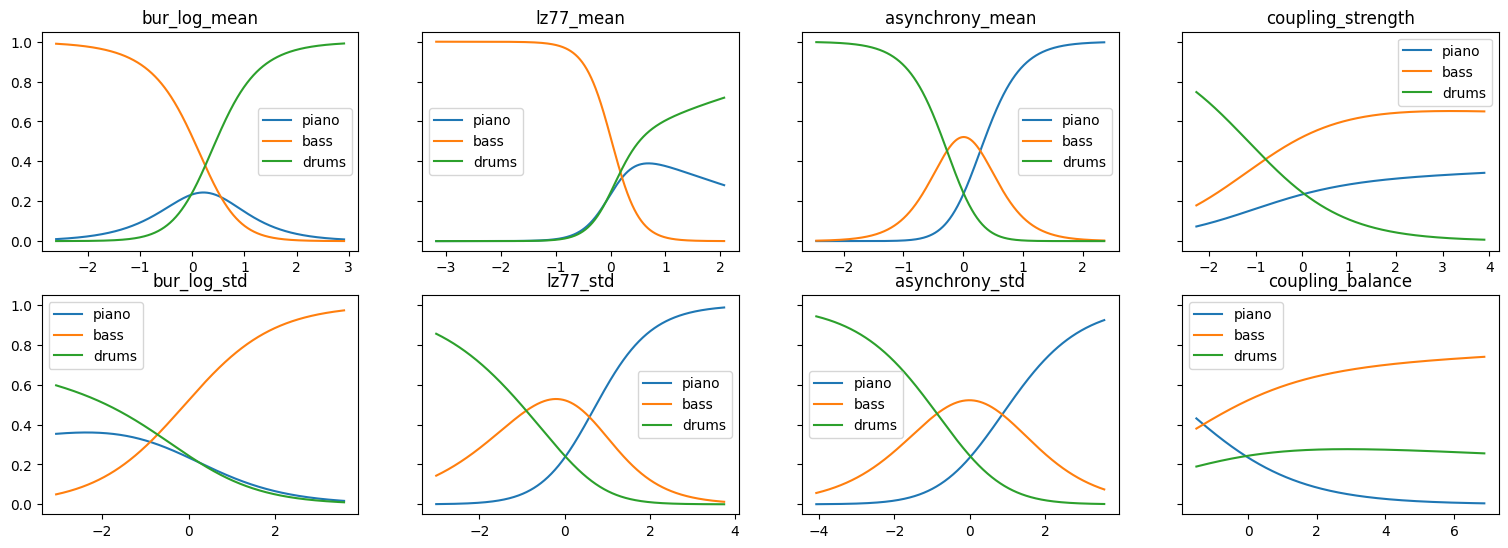

In [224]:
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(vutils.WIDTH, vutils.WIDTH / 3))
for to_predict, a in zip(X.columns, ax.flatten('F')):
    predict_var = {to_predict: np.linspace(X_[to_predict].min(), X_[to_predict].max(), len(X_))}
    pred_df = pd.DataFrame(predict_var | {col: [X_[col].mean() for _ in range(len(X_))] for col in X_.columns if col != to_predict})[list(X_.columns)]
    probs = pd.concat([lr.predict(pred_df).rename(columns={0: 'piano', 1: 'bass', 2: 'drums'}), pd.DataFrame(predict_var).rename(columns={to_predict: 'pred_var'})], axis=1)
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        a.plot(probs['pred_var'], probs[instr], label=instr)
    a.legend()
    a.set_title(to_predict)
plt.show()

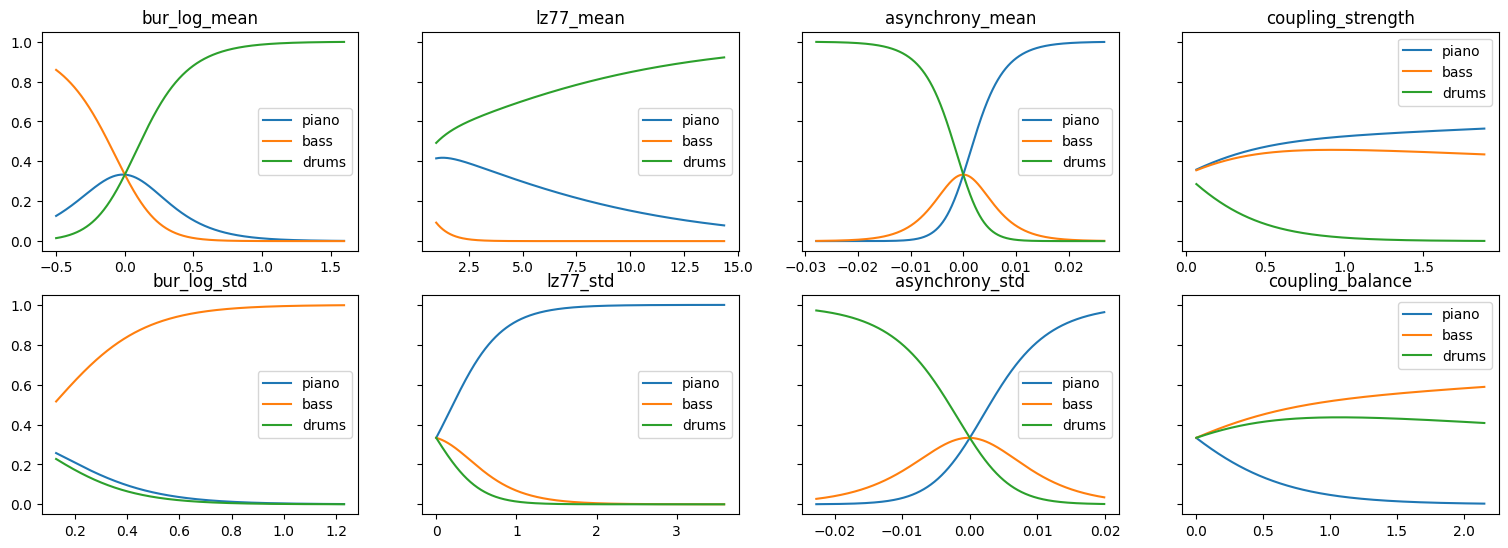

In [218]:
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(vutils.WIDTH, vutils.WIDTH / 3))
for to_predict, a in zip(X.columns, ax.flatten('F')):
    predict_var = {to_predict: np.linspace(X_[to_predict].min(), X_[to_predict].max(), len(X_))}
    pred_df = pd.DataFrame(predict_var | {col: [0 for _ in range(len(X_))] for col in X_.columns if col != to_predict})[list(X_.columns)]
    probs = pd.concat([lr.predict(pred_df).rename(columns={0: 'piano', 1: 'bass', 2: 'drums'}), pd.DataFrame(predict_var).rename(columns={to_predict: 'pred_var'})], axis=1)
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        a.plot(probs['pred_var'], probs[instr], label=instr)
    a.legend()
    a.set_title(to_predict)
plt.show()

## Visualise confusion matrix

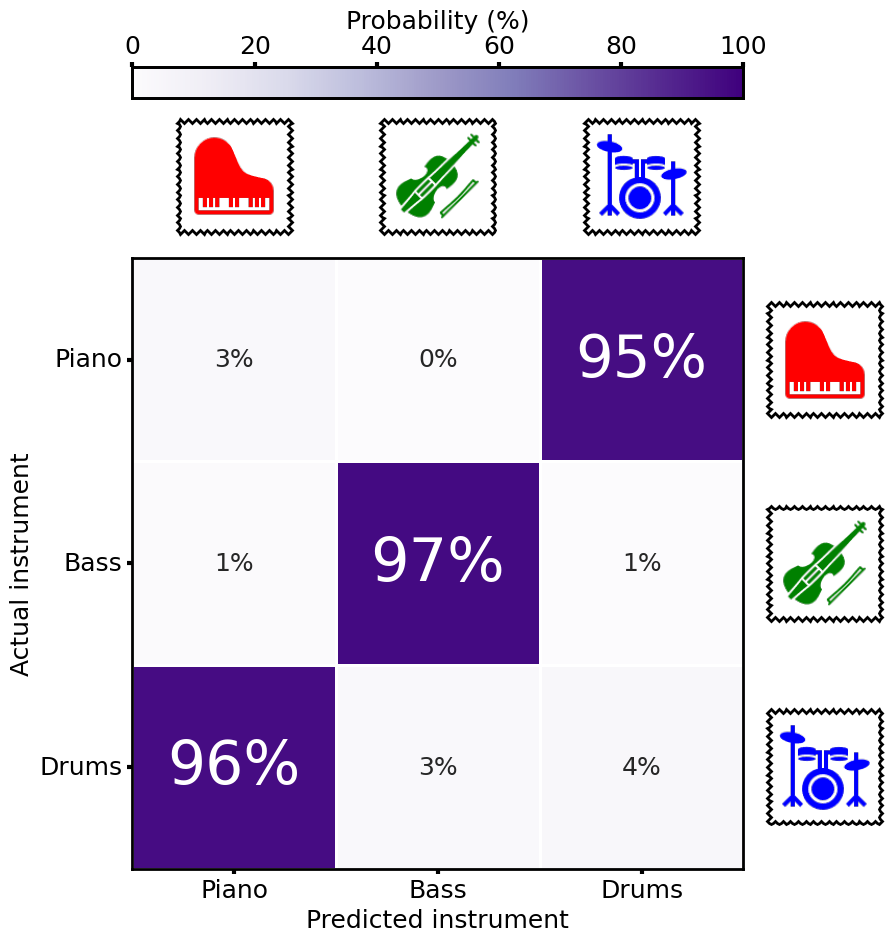

In [337]:
from sklearn.metrics import confusion_matrix

class HeatMapLogRegInstrument(vutils.BasePlot):
    img_loc = fr'{utils.get_project_root()}\references\images\musicians'

    def __init__(self, logreg_md, y_actual, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(
            figure_title=fr'logistic_regression_plots\heatmap_logreg_instrument_{self.corpus_title}', **kwargs
        )
        self.df = self._format_df(logreg_md, y_actual)
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))

    @staticmethod
    def _format_df(model, y_actual):
        model_df = pd.DataFrame(model.predict(), columns=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()).idxmax(axis=1)
        df_ = pd.concat([model_df, y_actual.str.replace('_', '')], axis=1).rename(columns={0: 'predicted', 'instrument': 'actual'})
        mat = pd.DataFrame(confusion_matrix(df_['actual'], df_['predicted'], normalize='true'))
        mat.columns = utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()
        mat.index = utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()
        return mat.transpose().reindex(reversed(utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()))

    def _create_plot(self):
        sns.heatmap(
            self.df * 100, ax=self.ax, cmap="Purples", linecolor=vutils.WHITE, annot=True,
            fmt='.0f', linewidths=vutils.LINEWIDTH/2, vmin=0, vmax=100, square=True,
            cbar_kws=dict(label='Probability (%)', use_gridspec=False, location="top", pad=0.1, shrink=0.65, orientation='horizontal')
        )

    def _add_instrument_images(self):
        for num, mus in enumerate(self.ax.get_xticklabels()):
            img = mpl.offsetbox.OffsetImage(
                plt.imread(fr'{self.img_loc}\_{mus.get_text()}.png'), clip_on=False, transform=self.ax.transAxes, zoom=0.75
            )
            ab = mpl.offsetbox.AnnotationBbox(
                img, (num + 0.5, -0.4), xycoords='data', clip_on=False, transform=self.ax.transAxes,
                annotation_clip=False, bboxprops=dict(
                    edgecolor=vutils.BLACK, lw=2, boxstyle='sawtooth', clip_on=False,
                ),
            )
            self.ax.add_artist(ab)
            ab = mpl.offsetbox.AnnotationBbox(
                img, (3.4, num + 0.5), xycoords='data', clip_on=False, transform=self.ax.transAxes,
                annotation_clip=False, bboxprops=dict(
                    edgecolor=vutils.BLACK, lw=2, boxstyle='sawtooth', clip_on=False,
                )
            )
            self.ax.add_artist(ab)

    def _format_annotations(self):
        texts = np.array(self.ax.texts).reshape(-1, 3)
        masks = np.fliplr(np.eye(texts.shape[0], dtype=bool))
        for text, mask in zip(texts.flatten(), masks.flatten()):
            if mask:
                text.set_fontsize((vutils.FONTSIZE * 2) * (int(text.get_text())) / 80)
                text.set_color(vutils.WHITE)
            text.set_text(text.get_text() + '%')

    def _format_ax(self):
        self._format_annotations()
        self._add_instrument_images()
        ti = [i.title() for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
        self.ax.set(
            xlabel='Predicted instrument', ylabel='Actual instrument', xticklabels=ti,
            yticklabels=ti
        )
        for ax_ in [self.ax, self.ax.figure.axes[-1]]:
            for spine in ax_.spines.values():
                spine.set_visible(True)
                spine.set_color(vutils.BLACK)
            plt.setp(ax_.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
            ax_.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK, rotation=0)

    def _format_fig(self):
        self.fig.subplots_adjust(top=1, bottom=0.05, left=0.15, right=0.95)
        pos = self.ax.get_position()
        self.ax.set_position([pos.x0, pos.y0 - 0.125, pos.width - 0.15, pos.height - 0.15])
        cax = self.ax.figure.axes[-1]
        cax.set_position([0.15, 0.895, 0.65, 0.35])

HeatMapLogRegInstrument(lr, y).create_plot()
plt.show()

## Visualise coefficients

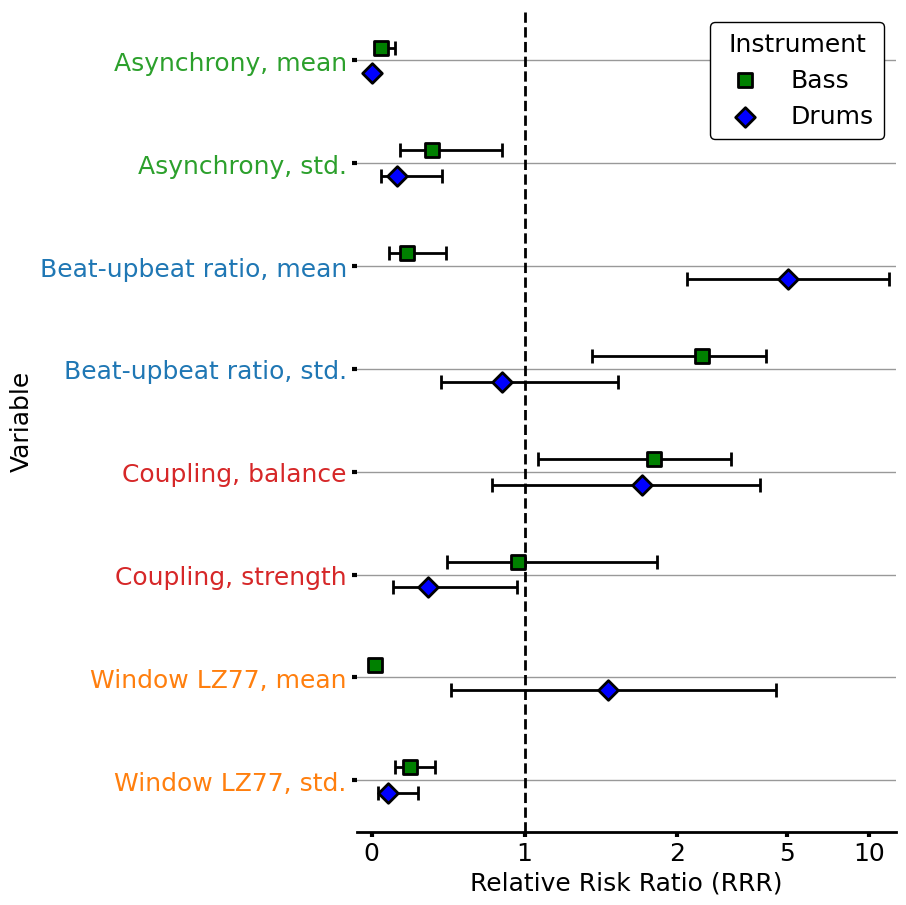

In [484]:
ci = lr.conf_int().apply(np.exp).reset_index(drop=False)
para = (
    lr.params
    .apply(np.exp)
    .rename(columns={0: 'bass', 1: 'drums'})
    .melt(var_name='instrument', value_name='coeff', ignore_index=False)
    .reset_index(drop=False)
    .rename(columns={'index': 'variable'})
    .sort_values(by=['variable', 'instrument'], ascending=False)
)
para = para[para['variable'] != 'const'].reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))
mapping = {
    'bass': {'color': vutils.RGB[1], 'marker': vutils.MARKERS[1]},
    'drums': {'color': vutils.RGB[2], 'marker': vutils.MARKERS[2]}
}
for idx, row in para.iterrows():
    y = idx + 0.25 if row['instrument'] == 'drums' else idx - 0.25
    x = row['coeff']
    ci_ = ci[(ci['instrument'] == row['instrument']) & (ci['level_1'] == row['variable'])]
    low, high = x - ci_['lower'], ci_['upper'] - x
    ax.errorbar(x, y, xerr=(low, high), lw=vutils.LINEWIDTH, color=vutils.BLACK, linestyle=vutils.LINESTYLE, capsize=5, elinewidth=2, markeredgewidth=2)
    ax.scatter(x, y, **mapping[row['instrument']], s=100, edgecolor=vutils.BLACK, lw=vutils.LINEWIDTH, zorder=5, label=row['instrument'])

ax.axvline(1, 0, 1, color=vutils.BLACK, lw=vutils.LINEWIDTH, ls='dashed', zorder=1, )
# xl = max([abs(i) for i in ax.get_xlim()])
mapping = {'asynchrony_mean': 'Asynchrony, mean', 'asynchrony_std': 'Asynchrony, std.', 'bur_log_mean': 'Beat-upbeat ratio, mean', 'bur_log_std': 'Beat-upbeat ratio, std.', 'coupling_balance': 'Coupling, balance', 'coupling_strength': 'Coupling, strength', 'lz77_mean': 'Window LZ77, mean', 'lz77_std': 'Window LZ77, std.' }
ax.set_xscale('symlog')
ax.set(yticks=[i + .5 for i in range(0, 16, 2)], yticklabels=[mapping[i] for i in para['variable'].unique()], ylim=(-0.5, 15.5), xlabel='Relative Risk Ratio (RRR)', xticks=[0, 1, 2, 5, 10], xticklabels=[0, 1, 2, 5, 10], xlim=(-0.1, 12.5), ylabel='Variable')
ax.grid(axis='y', which='major', **vutils.GRID_KWS)
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)
plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK, rotation=0)
hand, _ = ax.get_legend_handles_labels()
ax.legend(reversed(hand[-2:]), ['Bass', 'Drums'], loc='upper right', title='Instrument', frameon=True, framealpha=1, edgecolor=vutils.BLACK)

t10 =  sns.color_palette("tab10")
tcs = reversed([t10[2], t10[0], t10[3], t10[1]])
for tl, tc in zip(ax.get_yticklabels(), [item for item in tcs for i in range(2)]):
    tl.set_color(tc)
fig.tight_layout()
plt.show()

## Create plot of regression slopes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1

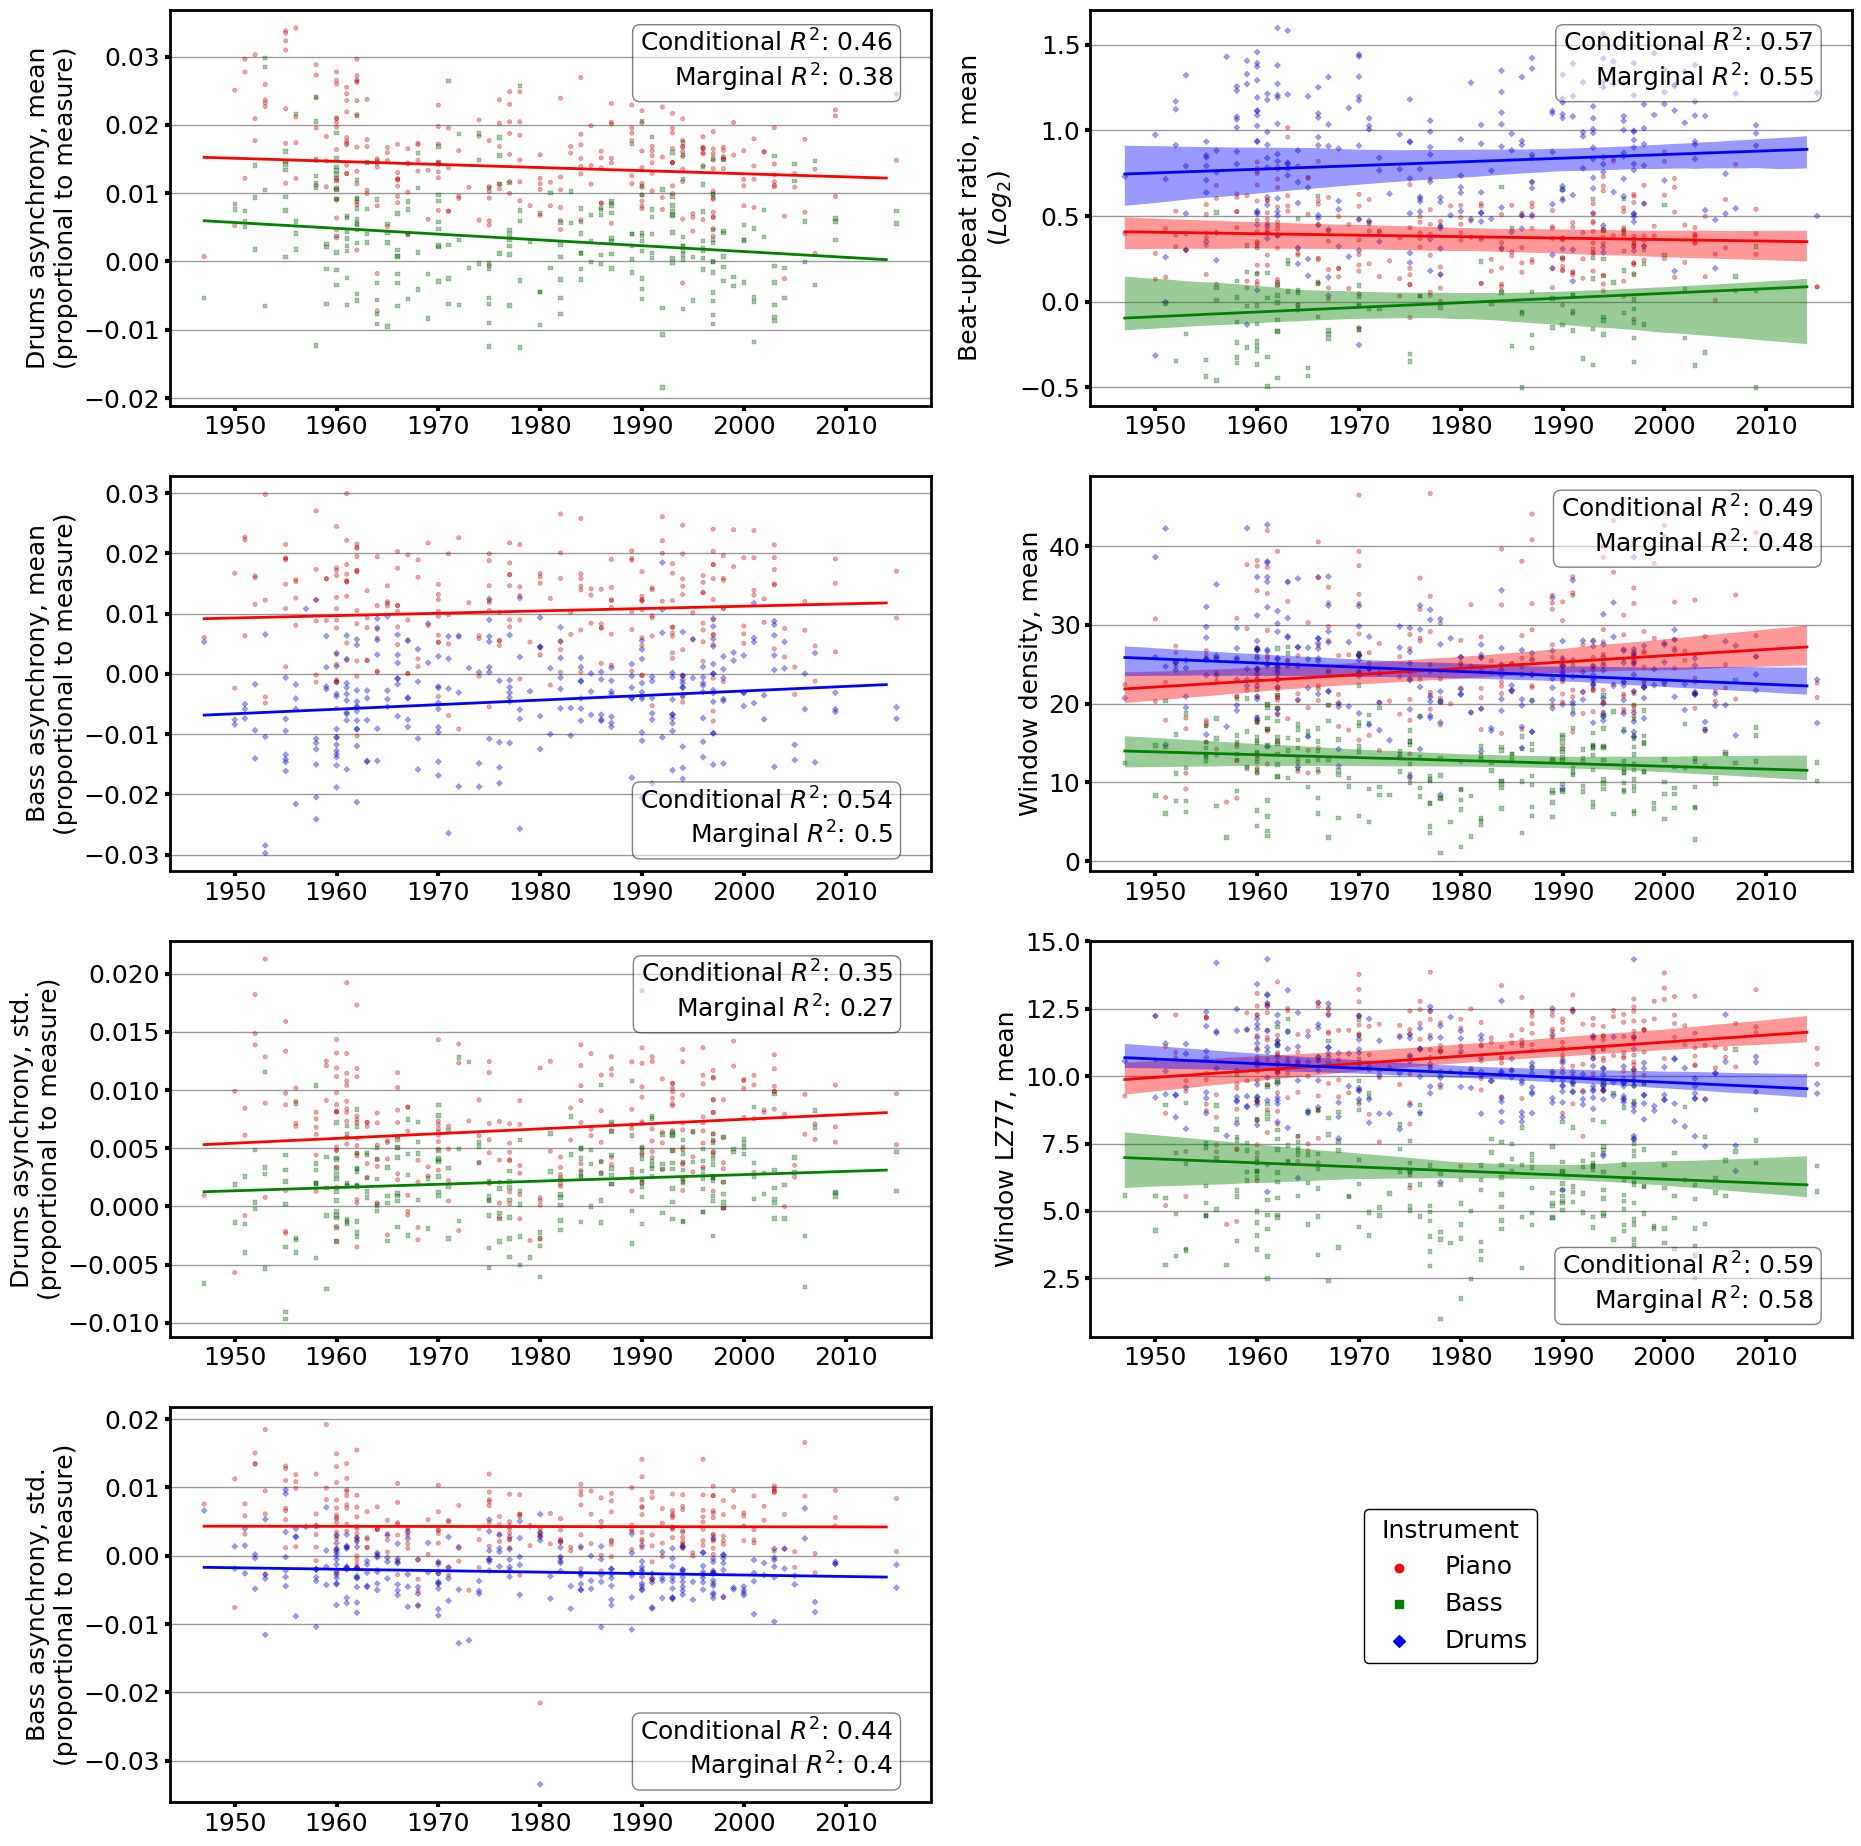

In [23]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy.stats as stats

class _RegPlotChronologyAx:
    """Base class for plotting a mixed linear regression onto an axis"""
    locs = dict(left=0.05, bottom=0.05, right=0.95, top=0.95)
    col_mapping = {i: c for i, c in zip(utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(), vutils.RGB)}
    # Disable convergence and user warnings here, raised when the model is created with bootstrapping
    warnings.simplefilter('ignore', ConvergenceWarning)
    warnings.simplefilter('ignore', UserWarning)
    # Method used for fitting the mixed linear model
    METHOD = ['lbfgs']
    # Number of bootstrapped replicates
    N_BOOT = 1000
    # These are the keywords we pass to each plotting object
    SCATTER_KWS = dict(
        palette=vutils.RGB, s=10, alpha=vutils.ALPHA, markers=['o', 's', 'D'],
        hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(), zorder=3,
        style_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),
        edgecolor=vutils.BLACK,
    )
    FILL_KWS = dict(alpha=vutils.ALPHA, edgecolor='none', zorder=5)
    LINE_KWS = dict(linewidth=vutils.LINEWIDTH, linestyle=vutils.LINESTYLE, zorder=10)
    # these are matplotlib.patch.Patch properties
    TEXT_KWS = dict(boxstyle='round', facecolor=vutils.WHITE, alpha=0.5)

    def __init__(self, subset, yvar, ref, ax_, **kwargs):
        self.yvar = yvar
        self.df = subset
        self.ref_level = ref
        self.ax = ax_
        self.low = int(np.floor(self.df['recording_year'].min()))
        self.high = int(np.ceil(self.df['recording_year'].max()))
        self.x_mean = np.array(range(self.low, self.high)).mean()
        self.x_std = np.array(range(self.low, self.high)).std()
        self.md = self.fit_model()
        self.ylabel = kwargs.get('ylabel', '')
        self.text_loc = kwargs.get('text_loc', 'upper left')
        # List of names of all bandleaders: we use this for bootstrapping
        self.bandleaders = pd.Series(self.df['pianist'].unique())
        self.hand, self.lab = None, None

    @staticmethod
    def get_r2(model) -> tuple:
        """Calculates conditional and marginal R2 for a given model"""
        # Variance explained by the fixed effects
        # We need to use md.predict() with the underlying data to get this
        var_fixed = model.predict().var()
        # Variance explained by the random effects
        var_random = float(model.cov_re.to_numpy().mean())
        # Variance of the residuals
        var_resid = model.scale
        # Total variance of the model
        total_var = var_fixed + var_random + var_resid
        # Calculate the r2 values and append to the model
        return (var_fixed + var_random) / total_var, var_fixed / total_var

    def get_bootstraped_sample(self, state: int) -> pd.DataFrame:
        """Returns bootstrapped sample of the full dataset"""
        samples = []
        # Take a random sample of bandleaders and iterate through each
        for _, leader in self.bandleaders.sample(frac=1, replace=True, random_state=state).items():
            # Get all the data belonging to each bandleader
            samples.append(self.df[self.df['pianist'] == leader])
        return pd.concat(samples, axis=0)

    def fit_model(self, data=None):
        """Fits the mixed linear model"""
        if data is None:
            data = self.df
        return smf.mixedlm(
            f"{self.yvar} ~ year_std * C(instrument, Treatment(reference='{self.ref_level}'))",
            data=data,
            groups=data['pianist'],
            re_formula=f"0 + year_std + C(instrument, Treatment(reference='{self.ref_level}'))"
        ).fit(method=self.METHOD)

    def predict_val(self, x, md_vars):
        """Placeholder, overridden in child classes"""
        return

    def get_model_vars(self, md_):
        """Placeholder, overridden in child classes"""
        return

    def get_line(self, md_vars: dict) -> pd.DataFrame:
        """Creates a line by predicting y values for all xs"""
        predicts = []
        for x in range(self.low, self.high):
            predicts.extend(self.predict_val(x, md_vars))
        return pd.DataFrame(predicts)

    @staticmethod
    def format_bootstrapped_line_df(bootstrap_res) -> pd.DataFrame:
        """Formats bootstrapped results into a single dataframe"""
        # Concatenate all lines to a single dataframe
        all_lines = pd.concat(bootstrap_res, axis=1)
        result_df = pd.DataFrame()
        # Apply functions to each row
        # These two lines just get the first value, they're all the same
        result_df['year'] = all_lines.apply(lambda r: r['year'].iloc[0], axis=1)
        result_df['instr'] = all_lines.apply(lambda r: r['instr'].iloc[0], axis=1)
        result_df['sem'] = all_lines.apply(lambda r: 1.96 * stats.sem(r['var']), axis=1)
        # These two lines get the upper and lower confidence interval
        result_df['low_ci'] = all_lines.apply(lambda r: np.percentile(r['var'], 2.5), axis=1)
        result_df['high_ci'] = all_lines.apply(lambda r: np.percentile(r['var'], 97.5), axis=1)
        # Return the result
        return result_df

    def get_bootstrapped_line(self) -> pd.DataFrame:
        """Creates a dataframe """
        # Open up a joblib context manager for parallel processing
        with Parallel(n_jobs=N_JOBS, verbose=5) as par:
            # Get our bootstrapped samples (each a dataframe)
            boot_samples = par(delayed(self.get_bootstraped_sample)(sta) for sta in range(self.N_BOOT))
            # Fit the model to all bootstrapped samples (each an individual mixed lm object)
            boot_models = par(delayed(self.fit_model)(sampl) for sampl in boot_samples)
            # Get the parameters from the bootstrapped model (each a dictionary)
            boot_params = par(delayed(self.get_model_vars)(model) for model in boot_models)
            # Create a line from the bootstrapped parameters (each a dataframe)
            boot_lines = par(delayed(self.get_line)(param) for param in boot_params)
        return self.format_bootstrapped_line_df(boot_lines)

    def add_r2_text(self) -> None:
        """Adds text showing conditional and marginal R2 to a plot"""
        conr2, margr2 = self.get_r2(self.md)
        textstr = f'Conditional $R^2$: {round(conr2, 2)}\nMarginal $R^2$: {round(margr2, 2)}'
        y_loc, x_loc = self.text_loc.split(' ')
        self.ax.text(
            self.locs[x_loc], self.locs[y_loc], textstr, ha=x_loc,
            transform=self.ax.transAxes, bbox=self.TEXT_KWS, va=y_loc
        )

    def format_ax(self) -> None:
        """Formats axis object"""
        self.add_r2_text()
        self.hand, self.lab = self.ax.get_legend_handles_labels()
        self.ax.get_legend().remove()
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.tick_params(axis='both', width=vutils.TICKWIDTH)
        self.ax.set(xlabel='', ylabel=self.ylabel)
        self.ax.grid(zorder=0, axis='y', **vutils.GRID_KWS)


class _RegPlotChronology3InstrsAx(_RegPlotChronologyAx):
    """Creates a regression plot on a given axis, with 3 levels (i.e. all instruments)"""

    def __init__(self, subset, yvar, ref, ax_, **kwargs):
        super().__init__(subset, yvar, ref, ax_, **kwargs)
        self.md_vars = self.get_model_vars(self.md)

    def predict_val(self, x, md_vars: dict) -> list:
        """Predicts y based on X and given model parameters"""
        # Standardise the X (Z-score) according to the observed values
        x_z = (x - self.x_mean) / self.x_std
        year_coeff = md_vars['year'] * x_z
        year_res = []
        # Iterate through each instrument and both coefficients
        for instr_, coeff_, interact_ in zip(
            utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),
            [0, md_vars['is_bass'], md_vars['is_drums']],
            [0, md_vars['is_bass_inter'], md_vars['is_drums_inter']]
        ):
            # Construct the y value by following the regression equation
            y_ = md_vars['intercept'] + year_coeff + coeff_ + (interact_ * x_z)
            # Yield a dictionary of the results
            year_res.append(dict(year=x, year_z=x_z, instr=instr_, var=y_))
        return year_res

    def get_model_vars(self, md_) -> dict:
        """Gets parameters from a given model"""
        return {
            'intercept': md_.params['Intercept'],
            'year': md_.params['year_std'],
            'is_bass': md_.params[f"C(instrument, Treatment(reference='{self.ref_level}'))[T.bass]"],
            'is_bass_inter': md_.params[f"year_std:C(instrument, Treatment(reference='{self.ref_level}'))[T.bass]"],
            'is_drums': md_.params[f"C(instrument, Treatment(reference='{self.ref_level}'))[T.drums]"],
            'is_drums_inter': md_.params[f"year_std:C(instrument, Treatment(reference='{self.ref_level}'))[T.drums]"],
        }

    def create_plot(self):
        """Creates the plot object"""
        # Create the scatterplot
        sns.scatterplot(
            data=self.df, x='recording_year', y=self.yvar, ax=self.ax,
            hue='instrument', style='instrument', **self.SCATTER_KWS
        )
        # Get our line from the main dataset
        line_ = self.get_line(md_vars=self.md_vars)
        # Get our bootstrapped line
        boot_line_ = self.get_bootstrapped_line()
        # Iterate through each instrument and color
        for col, (idx, li) in zip(vutils.RGB, line_.groupby('instr', sort=False)):
            # Plot the main effect line
            self.ax.plot(li['year'], li['var'], color=col, **self.LINE_KWS)
            # Subset to get the bootstrapped line for this instrument
            tb = boot_line_[boot_line_['instr'] == idx]
            # Fill between the low and high bounds
            self.ax.fill_between(tb['year'], tb['low_ci'], tb['high_ci'], color=col, **self.FILL_KWS)


class _RegPlotChronology2InstrsAx(_RegPlotChronologyAx):
    """Creates a regression plot on a given axis, with 3 levels (i.e. all instruments)"""

    def __init__(self, subset, yvar, ref, ax_, other, **kwargs):
        self.other_level = other
        super().__init__(subset, yvar, ref, ax_, **kwargs)
        self.md_vars = self.get_model_vars(self.md)

    def predict_val(self, x, md_vars) -> list:
        """Predicts a y value for all insturments based on x and observed coefficients"""
        # Standardise the X (Z-score) according to the observed values
        x_z = (x - self.x_mean) / self.x_std
        year_coeff = md_vars['year'] * x_z
        year_res = []
        # Iterate through each instrument and both coefficients
        for instr_, coeff_, interact_ in zip(
            [self.ref_level, self.other_level],
            [0, md_vars['is_other']],
            [0, md_vars['is_other_interact']]
        ):
            # Construct the y value by following the regression equation
            y_ = md_vars['intercept'] + year_coeff + coeff_ + (interact_ * x_z)
            # Yield a dictionary of the results
            year_res.append(dict(year=x, year_z=x_z, instr=instr_, var=y_))
        return year_res

    def get_model_vars(self, md_) -> dict:
        """Gets parameters from the model, for building the line"""
        return {
            # Get our intercept and tempo parameters from the model
            "intercept": md_.params['Intercept'],
            "year": md_.params['year_std'],
            # Get our other parameters from the model
            "is_other": md_.params[f"C(instrument, Treatment(reference='{self.ref_level}'))[T.{self.other_level}]"],
            "is_other_interact": md_.params[f"year_std:C(instrument, Treatment(reference='{self.ref_level}'))[T.{self.other_level}]"],
        }

    def create_plot(self):
        """Creates the plot object"""
        # Create the scatterplot
        sns.scatterplot(
            data=self.df, x='recording_year', y=self.yvar, ax=self.ax,
            hue='instrument', style='instrument', **self.SCATTER_KWS
        )
        # Get our line from the main dataset
        line_ = self.get_line(md_vars=self.md_vars)
        # Get our bootstrapped line
        boot_line_ = self.get_bootstrapped_line()
        # Iterate through each instrument and color
        for idx_, li_ in line_.groupby('instr', sort=False):
            col_ = self.col_mapping[idx_]
            # Plot the main effect line
            self.ax.plot(li_['year'], li_['var'], color=col_, **self.LINE_KWS)
            # Subset to get the bootstrapped line for this instrument
            tb = boot_line_[boot_line_['instr'] == idx_]
            # Fill between the low and high bounds
            self.ax.fill_between(
                tb['year'], li_['var'] - tb['sem'], li_['var'] + tb['sem'],
                color=col_, **self.FILL_KWS
            )


class RegPlotChronologyFeatures(vutils.BasePlot):
    """Central class for creating all regression plots"""
    # Dictionaries for every predictor, with related metadata (number of instruments, reference levels)
    predictors = {
        'drums_prop_async_nanmean': {
            'n_instr': 2,
            'ref_level': 'piano',
            'other_level': 'bass',
            'ylabel': 'Drums asynchrony, mean\n(proportional to measure)',
            'text_loc': 'top right'
        },
        'bur_log_mean': {
            'n_instr': 3,
            'ref_level': 'piano',
            'ylabel': 'Beat-upbeat ratio, mean\n($Log_2$)',
            'text_loc': 'top right'
        },
        'bass_prop_async_nanmean': {
            'n_instr': 2,
            'ref_level': 'piano',
            'other_level': 'drums',
            'ylabel': 'Bass asynchrony, mean\n(proportional to measure)',
            'text_loc': 'bottom right'
        },
        'n_onsets_mean': {
            'n_instr': 3,
            'ref_level': 'piano',
            'ylabel': 'Window density, mean',
            'text_loc': 'top right'
        },
        'drums_prop_async_nanstd': {
            'n_instr': 2,
            'ref_level': 'piano',
            'other_level': 'bass',
            'ylabel': 'Drums asynchrony, std.\n(proportional to measure)',
            'text_loc': 'top right'
        },
        'lz77_mean': {
            'n_instr': 3,
            'ref_level': 'piano',
            'ylabel': 'Window LZ77, mean',
            'text_loc': 'bottom right'
        },
        'bass_prop_async_nanstd': {
            'n_instr': 2,
            'ref_level': 'piano',
            'other_level': 'drums',
            'ylabel': 'Bass asynchrony, std.\n(proportional to measure)',
            'text_loc': 'bottom right'
        },
    }

    def __init__(self, features_df: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fr'chronology_plots\regplot_yearfeatures_{self.corpus_title}', **kwargs)
        self.df = features_df.copy(deep=True)
        self.fig, self.ax = plt.subplots(nrows=4, ncols=2, figsize=(vutils.WIDTH, vutils.WIDTH))
        self.ax[-1, -1].axis('off')
        self.rps = []

    def _create_plot(self):
        """Creates all regression plots"""
        for ax_, (feature, meta) in zip(self.ax.flatten(), self.predictors.items()):
            data_sub = self.df.copy(deep=True).dropna(subset=feature)
            if meta['n_instr'] == 2:
                rp = _RegPlotChronology2InstrsAx(
                    subset=data_sub, yvar=feature, ref=meta['ref_level'],
                    other=meta['other_level'], ax_=ax_, ylabel=meta['ylabel'],
                    text_loc=meta['text_loc']
                )
            else:
                rp = _RegPlotChronology3InstrsAx(
                    subset=data_sub, yvar=feature, ref=meta['ref_level'],
                    ax_=ax_, ylabel=meta['ylabel'], text_loc=meta['text_loc']
                )
            rp.create_plot()
            rp.format_ax()
            self.rps.append(rp)

    def _format_fig(self):
        """Formats figure level parameters"""
        self.fig.legend(
            self.rps[-1].hand, ['Piano', 'Bass', 'Drums'], loc='lower right', bbox_to_anchor=(0.825, 0.1),
            title='Instrument', frameon=True, framealpha=1, edgecolor=vutils.BLACK
        )
        self.fig.tight_layout()


RegPlotChronologyFeatures(clean).create_plot()

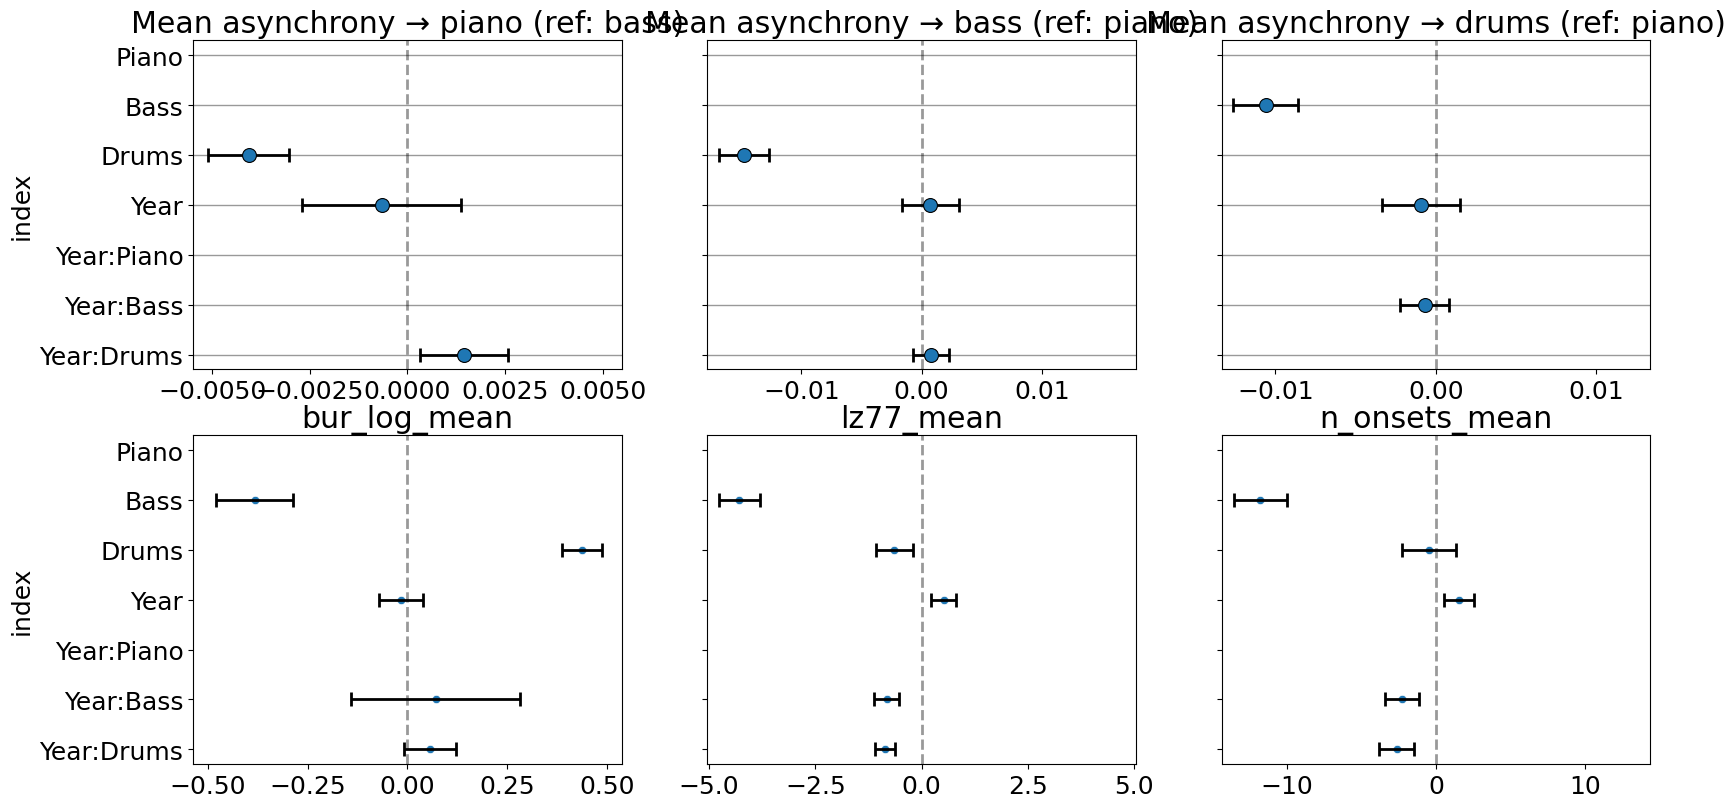

In [24]:
def fit_model(yvar: str, data: pd.DataFrame, ref: str = 'piano'):
    return smf.mixedlm(
        f"{yvar} ~ year_std * C(instrument, Treatment(reference='{ref}'))",
        data=data,
        groups=data['pianist'],
        re_formula=f"0 + year_std + C(instrument, Treatment(reference='{ref}'))"
    ).fit(method=['lbfgs'], reml=False)

def index_rename(val):
    val = val.replace('year_std', 'year')
    if 'C(' in val:
        p1 = val.split('C(')
        val = p1[0] + p1[1].split("T.")[1].replace(']', '')
    return val.title()

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(vutils.WIDTH, vutils.WIDTH / 2))

for a, var_ in zip(ax.flatten()[3:], ['bur_log_mean', 'lz77_mean', 'n_onsets_mean']):
    sub = clean.copy(deep=True).dropna(subset=var_)
    md = fit_model(var_, sub)
    coeffs = md.params.iloc[1:6].rename('beta')
    conf_int = md.conf_int().iloc[1:6].rename(columns={0: 'low', 1: 'high'})
    comb = pd.merge(coeffs, conf_int, left_index=True, right_index=True)
    comb.index = comb.index.map(index_rename)
    comb = comb.reset_index(drop=False)
    fake1 = pd.DataFrame(pd.Series({'index': 'Piano', 'beta': np.nan, 'low': np.nan, 'high': np.nan})).transpose()
    fake2 = pd.DataFrame(pd.Series({'index': 'Year:Piano', 'beta': np.nan, 'low': np.nan, 'high': np.nan})).transpose()
    comb = pd.concat([comb, fake1, fake2], ignore_index=True)
    comb['low'] = comb['beta'] - comb['low']
    comb['high'] = comb['high'] - comb['beta']
    comb = comb.reindex([5, 0, 1, 2, 6, 3, 4])
    g = sns.scatterplot(data=comb, x='beta', y='index', ax=a)
    a.errorbar(x=comb['beta'], y=comb['index'], xerr=(comb['low'], comb['high']), linestyle='none', color=vutils.BLACK, lw=vutils.LINEWIDTH, zorder=10, capsize=5, elinewidth=2, markeredgewidth=2)
    xl = max([abs(i) for i in g.get_xlim()])
    g.set(xlim=(-xl, xl), title=var_, xlabel='')
    g.axvline(x=0, ymin=0, ymax=7, color=vutils.BLACK, ls='dashed', lw=vutils.LINEWIDTH, alpha=vutils.ALPHA)

for a, instr in zip(ax.flatten()[:3], utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),):
    var_ = f'{instr}_prop_async_nanmean'
    sub = clean.copy(deep=True).dropna(subset=var_)
    ref_instr = sub['instrument'].unique()[0]
    other_instr = sub['instrument'].unique()[1]
    md = fit_model(var_, sub, ref_instr)
    coeffs = md.params.iloc[1:4].rename('beta')
    conf_int = md.conf_int().iloc[1:4].rename(columns={0: 'low', 1: 'high'})
    comb = pd.merge(coeffs, conf_int, left_index=True, right_index=True)
    comb.index = comb.index.map(index_rename)
    comb = comb.reset_index(drop=False)
    comb['low'] = comb['beta'] - comb['low']
    comb['high'] = comb['high'] - comb['beta']
    g = sns.scatterplot(data=comb, x='beta', y='index', ax=a, s=100, zorder=100, edgecolor=vutils.BLACK)
    a.grid(axis='y', **vutils.GRID_KWS)
    a.errorbar(x=comb['beta'], y=comb['index'], xerr=(comb['low'], comb['high']), linestyle='none', color=vutils.BLACK, lw=vutils.LINEWIDTH, zorder=10, capsize=5, elinewidth=2, markeredgewidth=2)
    xl = max([abs(i) for i in g.get_xlim()])
    g.set(xlim=(-xl, xl), title=f'Mean asynchrony → {instr} (ref: {ref_instr})', xlabel='')
    g.axvline(x=0, ymin=0, ymax=7, color=vutils.BLACK, ls='dashed', lw=vutils.LINEWIDTH, alpha=vutils.ALPHA, zorder=0)

plt.show()